In [ ]:
!rm -r *
!git clone https://github.com/LudoRey/dip-deblur/
!mv dip-deblur/* ./
!rm -r dip-deblur

In [19]:
import torch
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from unet import *
from utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

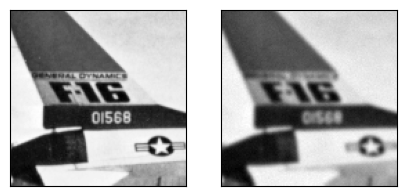

In [20]:
# Read image and create degraded version

im = read_img('data/airplane.tif', as_tensor=True).to(device)
ker = gaussian_kernel(sigma=1.2, as_tensor=True).to(device)

im_blur = blur(im, ker)
im_blur_noisy = gaussian_noise(im_blur, sigma=1e-2)

fig, axes = plt.subplots(1,2, figsize=(5,10))
axes[0].imshow(to_numpy(im), cmap='gray')
axes[1].imshow(to_numpy(im_blur_noisy), cmap='gray')
for ax in axes:
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()

In [21]:
nb_epoch = 4000
learning_rate = 0.01
input = (torch.rand(1,32,128,128)/10).to(device)
criterion = nn.MSELoss()

net_params = {'feature_channels' : 128, 'skip_channels' : 4, 'depth' : 4}

psnr_tracker = []
loss_tracker = []

# Create network
model = Unet(in_channels=input.shape[1], out_channels=1, **net_params)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Optimizing loop
model.train()
for i_epoch in range(nb_epoch):
    optimizer.zero_grad()
    im_recon = model(input)
    loss = criterion(blur(im_recon, ker), im_blur_noisy)
    loss.backward()
    optimizer.step()
    if (i_epoch+1) % 100 == 0:
        metric = psnr(to_numpy(im), to_numpy(im_recon))
        print(' [-] epoch {:}/{:}, loss {:.6f}, psnr {:.5f}'.format(i_epoch+1, nb_epoch, loss.item(), metric))
    psnr_tracker.append(psnr(to_numpy(im), to_numpy(im_recon)))
    loss_tracker.append(loss.item())

 [-] epoch 100/4000, loss 0.000949, psnr 23.97700
 [-] epoch 200/4000, loss 0.000263, psnr 27.27801
 [-] epoch 300/4000, loss 0.000151, psnr 28.99672
 [-] epoch 400/4000, loss 0.000130, psnr 29.69655
 [-] epoch 500/4000, loss 0.000108, psnr 30.31514
 [-] epoch 600/4000, loss 0.000102, psnr 30.57179
 [-] epoch 700/4000, loss 0.000101, psnr 30.70931
 [-] epoch 800/4000, loss 0.000105, psnr 30.78639
 [-] epoch 900/4000, loss 0.000093, psnr 30.98421
 [-] epoch 1000/4000, loss 0.000094, psnr 30.98347
 [-] epoch 1100/4000, loss 0.000092, psnr 31.07851
 [-] epoch 1200/4000, loss 0.000089, psnr 31.15514
 [-] epoch 1300/4000, loss 0.000088, psnr 31.18200
 [-] epoch 1400/4000, loss 0.000113, psnr 31.07338
 [-] epoch 1500/4000, loss 0.000087, psnr 31.21698
 [-] epoch 1600/4000, loss 0.000089, psnr 31.19567
 [-] epoch 1700/4000, loss 0.000085, psnr 31.21947
 [-] epoch 1800/4000, loss 0.000085, psnr 31.20015
 [-] epoch 1900/4000, loss 0.000084, psnr 31.19397
 [-] epoch 2000/4000, loss 0.000083, psn

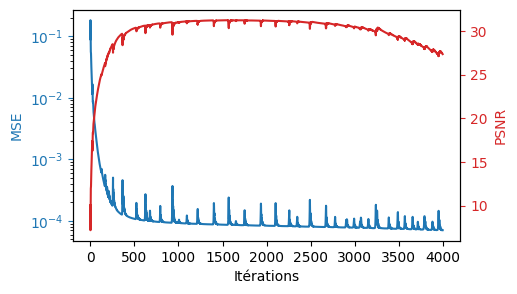

In [22]:
fig, ax1 = plt.subplots(1,1, figsize=(5,3))

ax1.plot(loss_tracker, color='C0')
ax1.set_xlabel('Itérations')
ax1.set_yscale('log')
ax1.set_ylabel('MSE', color='C0')
ax1.tick_params(axis='y', labelcolor='C0', color='C0')
ax2 = ax1.twinx()
ax2.plot(psnr_tracker, color='C3')
ax2.set_ylabel('PSNR', color='C3')
ax2.tick_params(axis='y', labelcolor='C3', color='C3')
  
plt.show()
#fig.savefig('figs/overfit.png', dpi=300, bbox_inches='tight', transparent=True)